In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn
from datetime import datetime
import locale
import time
from random import randint
import math

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [3]:
pd.set_option('display.min_rows', 30)

In [5]:
noise_data = pd.read_csv("Data/hourly_noisedata_2022.csv", header = 0, sep=',')
noise_data.head()

,month,day,hour,description,lamax,laeq,date,lamax_standardized,laeq_standardized
0,1,1,0,MP 03: Naamsestraat 62 Taste,60.322528,57.126833,00:00 01-01-2022,1.248969,1.044063
1,1,1,0,MP 05: Calvariekapel KU Leuven,53.230972,49.987639,00:00 01-01-2022,0.114661,-0.103638
2,1,1,0,MP 06: Parkstraat 2 La Filosovia,53.666056,50.752000,00:00 01-01-2022,0.184253,0.019241
3,1,1,0,MP 07: Naamsestraat 81,50.056861,47.440222,00:00 01-01-2022,-0.393044,-0.513162
4,1,1,1,MP 03: Naamsestraat 62 Taste,53.033583,50.853806,01:00 01-01-2022,0.083088,0.035608


In [6]:
noise_data = noise_data[noise_data["description"] == "MP 03: Naamsestraat 62 Taste"]
print(noise_data)
#Just location 3 for now

       month  day  hour                   description      lamax       laeq   
0          1    1     0  MP 03: Naamsestraat 62 Taste  60.322528  57.126833  \
4          1    1     1  MP 03: Naamsestraat 62 Taste  53.033583  50.853806   
8          1    1     2  MP 03: Naamsestraat 62 Taste  52.173702  50.049903   
12         1    1     3  MP 03: Naamsestraat 62 Taste  50.821311  48.964907   
16         1    1     4  MP 03: Naamsestraat 62 Taste  49.134851  47.285893   
20         1    1     5  MP 03: Naamsestraat 62 Taste  49.447680  47.538650   
24         1    1     6  MP 03: Naamsestraat 62 Taste  47.425444  46.146806   
28         1    1     7  MP 03: Naamsestraat 62 Taste  47.807917  46.299889   
32         1    1     8  MP 03: Naamsestraat 62 Taste  47.407583  46.047583   
36         1    1     9  MP 03: Naamsestraat 62 Taste  47.685861  46.281444   
40         1    1    10  MP 03: Naamsestraat 62 Taste  49.305611  47.921917   
44         1    1    11  MP 03: Naamsestraat 62 Tast

In [6]:
noise_month = noise_data[noise_data["month"] == 3]  
noise_day = noise_month[noise_month["day"] == 27]
len(noise_day)

23

In [7]:
weather_data = pd.read_csv("Data/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_data.head()

,Month,Day,Hour,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_TEMP_QCL3
0,1,1,0,0.000023,0.002997,-33.566358,1.487099,15.513391
1,1,1,1,0.000019,0.002174,-29.188272,1.465571,15.770757
2,1,1,2,0.000003,0.000360,-18.197324,0.389565,13.100358
3,1,1,3,0.000007,0.000000,-16.227891,0.222602,12.669197
4,1,1,4,0.000009,0.000000,-13.710884,0.217194,12.520271


In [9]:
noise_series = pd.Series(noise_data['laeq'])
temp_series = pd.Series(weather_data['LC_TEMP_QCL3'])
rain_series = pd.Series(weather_data['LC_RAININ'])
rain_cumul_series = pd.Series(weather_data['LC_DAILYRAIN'])
windspeed_series = pd.Series(weather_data['LC_WINDSPEED'])
month = pd.Series(weather_data['Month'])
day = pd.Series(weather_data['Day'])
hour = pd.Series(weather_data['Hour'])

In [10]:
len(noise_series)

8759

In [11]:
len(temp_series)

8760

In [12]:
len(rain_series)

8760

In [10]:
#Forward impute single observation in noise series on March 27 2AM
noise_series.loc[9430] = 50.700694
noise_series = noise_series.sort_index()
noise_series = noise_series.reset_index().drop('index', axis = 1)
print(noise_series)

           laeq
0     57.126833
1     50.853806
2     50.049903
3     48.964907
4     47.285893
5     47.538650
6     46.146806
7     46.299889
8     46.047583
9     46.281444
10    47.921917
11    49.678472
12    50.390556
13    50.540889
14    52.116306
...         ...
8745  52.189000
8746  51.514833
8747  52.668944
8748  54.153028
8749  53.602306
8750  53.702556
8751  53.138528
8752  52.667750
8753  52.909639
8754  53.995111
8755  53.559333
8756  52.055583
8757  50.424556
8758  51.030861
8759  56.661017

[8760 rows x 1 columns]


In [11]:
#Day of week one hot encoding. Go for 24 hours, skip 144. Year starts on a saturday
lst = [6, 7, 1, 2, 3, 4, 5]
lst_new = list(np.repeat(lst,24))
lst_newnew = lst_new * 53
day = np.array(lst_newnew[0:8760])

weekday = pd.get_dummies(day, prefix=['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri'])


In [12]:
#Get holidays
holiday_df = pd.read_csv("Data/Holidays.csv", header = 0, sep=',')
holiday_list = holiday_df['Date'].tolist()

locale.setlocale(locale.LC_TIME, 'nl_NL')

formatted_holidays = []
for date_str in holiday_list:
    date_obj = datetime.strptime(date_str, "%d %b")
    formatted_holidays.append(date_obj)

formatted_holidays = [date_obj.strftime("%m-%d") for date_obj in formatted_holidays]
prefix = '2022-'
formatted_holidays = [prefix + i for i in formatted_holidays]


start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:59:59'
index = pd.date_range(start=start_date, end=end_date, freq='H')
df = pd.DataFrame(index=index)

df['Holiday'] = 0

for holiday in formatted_holidays:
    df.loc[holiday, 'Holiday'] = 1

holiday = pd.Series(df['Holiday'])
holiday_series = holiday.reset_index(drop = True)
len(holiday_series)

8760

In [13]:
#Combine into a feature matrix
features = pd.concat([hour, weekday, holiday_series, temp_series, rain_series, rain_cumul_series, windspeed_series], axis=1)
display(features)

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,0,False,False,False,False,False,True,False,1,15.513391,0.000023,0.002997,1.487099
1,1,False,False,False,False,False,True,False,1,15.770757,0.000019,0.002174,1.465571
2,2,False,False,False,False,False,True,False,1,13.100358,0.000003,0.000360,0.389565
3,3,False,False,False,False,False,True,False,1,12.669197,0.000007,0.000000,0.222602
4,4,False,False,False,False,False,True,False,1,12.520271,0.000009,0.000000,0.217194
5,5,False,False,False,False,False,True,False,1,12.386194,0.000000,0.000000,0.178248
6,6,False,False,False,False,False,True,False,1,12.080706,0.000000,0.000000,0.237670
7,7,False,False,False,False,False,True,False,1,11.227068,0.000005,0.000007,0.143759
8,8,False,False,False,False,False,True,False,1,10.796072,0.000000,0.000010,0.100765
9,9,False,False,False,False,False,True,False,1,10.694374,0.000003,0.000015,0.140680


In [14]:
#Hour trig encoding
features['hour_sin'] = features['Hour'].apply(lambda x: math.sin(2*math.pi * x / 24))
features['hour_cos'] = features['Hour'].apply(lambda x: math.cos(2*math.pi * x / 24))
features = features.drop('Hour', axis = 1)
display(features)

,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
0,False,False,False,False,False,True,False,1,15.513391,0.000023,0.002997,1.487099,0.000000e+00,1.000000e+00
1,False,False,False,False,False,True,False,1,15.770757,0.000019,0.002174,1.465571,2.588190e-01,9.659258e-01
2,False,False,False,False,False,True,False,1,13.100358,0.000003,0.000360,0.389565,5.000000e-01,8.660254e-01
3,False,False,False,False,False,True,False,1,12.669197,0.000007,0.000000,0.222602,7.071068e-01,7.071068e-01
4,False,False,False,False,False,True,False,1,12.520271,0.000009,0.000000,0.217194,8.660254e-01,5.000000e-01
5,False,False,False,False,False,True,False,1,12.386194,0.000000,0.000000,0.178248,9.659258e-01,2.588190e-01
6,False,False,False,False,False,True,False,1,12.080706,0.000000,0.000000,0.237670,1.000000e+00,6.123234e-17
7,False,False,False,False,False,True,False,1,11.227068,0.000005,0.000007,0.143759,9.659258e-01,-2.588190e-01
8,False,False,False,False,False,True,False,1,10.796072,0.000000,0.000010,0.100765,8.660254e-01,-5.000000e-01
9,False,False,False,False,False,True,False,1,10.694374,0.000003,0.000015,0.140680,7.071068e-01,-7.071068e-01


In [14]:
np.corrcoef(noise_series, temp_series)
#Positively correlated with temperature as expected

array([[1.        , 0.22365862],
       [0.22365862, 1.        ]])

In [15]:
np.corrcoef(noise_series, rain_series)
#Positively correlated with rain?

array([[1.        , 0.17214263],
       [0.17214263, 1.        ]])

In [16]:
np.corrcoef(noise_series, rain_cumul_series)

array([[1.        , 0.07950235],
       [0.07950235, 1.        ]])

In [17]:
np.corrcoef(noise_series, windspeed_series) 
#ofc more wind more noise

array([[1.        , 0.20323506],
       [0.20323506, 1.        ]])

In [127]:
#Lagged crosscorrelation with temp
crosscor = sm.tsa.stattools.ccf(temp_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.22365862  0.2142166   0.18724367  0.14290011  0.08436395  0.01643265
 -0.05418668 -0.12136306 -0.18019974 -0.22598216 -0.25540294 -0.26608084
 -0.25772045 -0.2319899  -0.19258968 -0.14379399 -0.09017662 -0.03540677
  0.01834559  0.06954472  0.1156653   0.15515311  0.18634794  0.20717762
  0.2146224   0.20541942  0.17815155  0.13357491  0.07503406  0.0072108
 -0.06373958 -0.13152592 -0.19092213 -0.23744135 -0.26756308 -0.27866947
 -0.27017309 -0.24418608 -0.20441847 -0.15518905 -0.10128307 -0.04654117
  0.00679964  0.05724626  0.10308905  0.14229216  0.17360959  0.1946576
  0.20228387  0.19351143]


In [128]:
#Lagged crosscorrelation with rain
crosscor = sm.tsa.stattools.ccf(rain_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.17214263  0.17982325  0.17603795  0.16421999  0.14329122  0.11909052
  0.09682295  0.07484539  0.05002924  0.02044498 -0.01157186 -0.04355385
 -0.07342476 -0.09890932 -0.1213651  -0.13337976 -0.12660959 -0.09745228
 -0.05530641 -0.01112555  0.03049002  0.06640684  0.09667412  0.11776471
  0.13137859  0.13642016  0.13184591  0.11946939  0.09952919  0.07778231
  0.05516712  0.03244995  0.00893798 -0.01580532 -0.04162226 -0.06694264
 -0.09051169 -0.11061532 -0.12661013 -0.13479366 -0.127126   -0.09900248
 -0.05700455 -0.01170359  0.03092194  0.06754651  0.09709388  0.11530865
  0.12625662  0.13087008]


In [15]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(features, noise_series,
    test_size=0.2)

#Convert target variables to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [16]:
#Random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
#Random forest evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 2.5719044143076446
Mean Absolute Error (MAE): 1.1452206315807296
R-squared Score (R2): 0.8260704467245119


In [52]:
#Try to improve the model with small grid search
start_time = time.time()
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [None],       # Maximum depth of each tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4]     # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [53]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 55.94 seconds


In [54]:
#Evaluate grid-search fitted rf
predictions1 = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions1)
mae = mean_absolute_error(y_test, predictions1)
r2 = r2_score(y_test, predictions1)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)
#Actually much better but need more computational power to do a proper search

Mean Squared Error (MSE): 2.530220401385362
Mean Absolute Error (MAE): 1.132180002297225
R-squared Score (R2): 0.8254560003554295


In [49]:
#Try randomized search to save on computation time
start_time = time.time()
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of trees in the forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None] + list(range(5, 30, 5)), #Maximum depth of the trees
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to be at a leaf node 
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1
)

random_search.fit(X_train, y_train)
bestr_model = random_search.best_estimator_
best_params = random_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print(best_params)
#Best parameters {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}


In [50]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 1965.06 seconds


In [18]:
#So this cell is the random search-tuned model with its final hyperparameters
finalmodel = RandomForestRegressor()
bestparams = {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 1.0}
finalmodel.set_params(**bestparams)
finalmodel.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [19]:
#Evaluating randomized search-tuned model
predictions2 = finalmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions2)
mae = mean_absolute_error(y_test, predictions2)
r2 = r2_score(y_test, predictions2)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 2.57629776585758
Mean Absolute Error (MAE): 1.1438406765709812
R-squared Score (R2): 0.8257733386095246


Elapsed time to compute the importances: 29.171 seconds


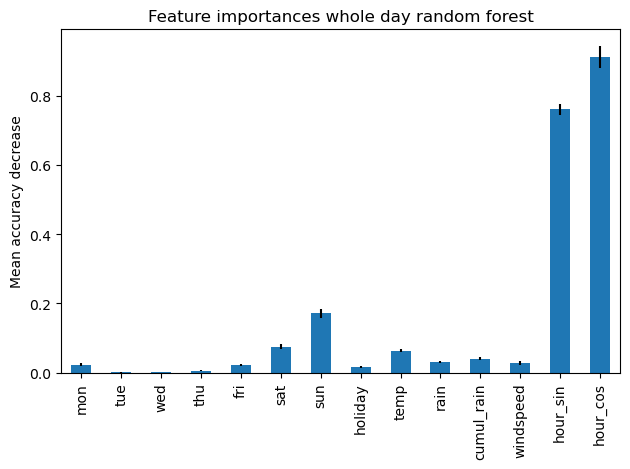

In [20]:
start_time = time.time()
result = permutation_importance(
    finalmodel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'holiday', 
                                                               'temp', 'rain', 'cumul_rain', 'windspeed', 'hour_sin', 'hour_cos'])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances whole day random forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

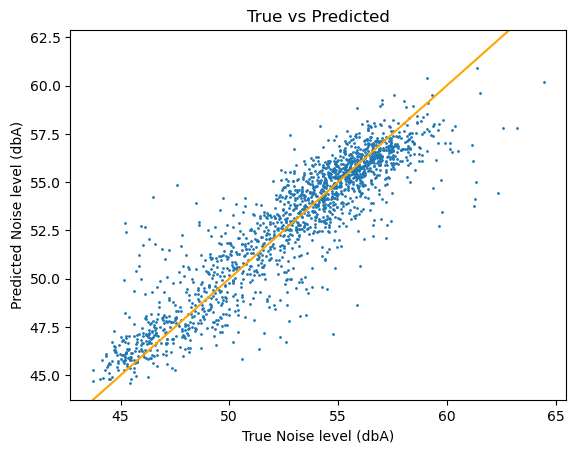

In [32]:
#Plot predicted values against true ones
plt.scatter(y_test, predictions2, s=1)
plt.axline((48, 48), (62, 62), color = 'orange')
plt.xlabel('True Noise level (dbA)')
plt.ylabel('Predicted Noise level (dbA)')
plt.title('True vs Predicted')
plt.show()
#If the predictions were perfect, every point would be on the orange line
#If a point is below the line it is underestimated, if it is above it is overestimated
#For high observations it tends to underestimate, for low it overestimates somewhat
#Somewhat high variance from 45-55, but prediction is very good around 55-60

In [38]:
#nr of over/underestimations
num = 0
over = 0
for i in y_test:
    if i < predictions2[[num]]:
        over += 1
    num +=1
print("Overpredictions:", over, "Underpredictions:", len(y_test) - over)

Overpredictions: 897 Underpredictions: 855


In [42]:
#Partial dependence
dependencefeatures = [8]
pdp_results = partial_dependence(finalmodel, features, features=dependencefeatures, method = 'recursion')

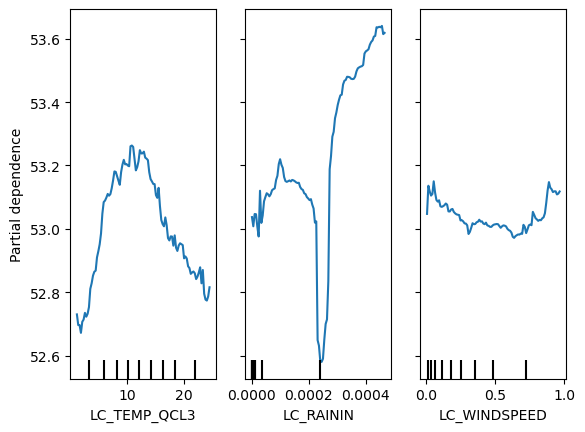

In [51]:
#Plot partial dependence
PartialDependenceDisplay.from_estimator(finalmodel, features, [8, 9, 11])